In [1]:
# loading library
import os, sys, csv

# loading scikitlearn lib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# selection metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn import metrics

# scoring = ['precision_macro', 'recall_macro']

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


# Feature selections
# Removing features with low variance (automatically remove zero and certain threshold)
from sklearn.feature_selection import VarianceThreshold
# Univariate feature selection
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2
# Tree based feature elimination
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# recursive feature elimination
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE

# Classifiers 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV # search best hyper-parameters
from sklearn.model_selection import train_test_split

In [34]:
# extra import
import copy
import random
# functions 

# returns header and descriptorValues
def readDataFromCSV(csvfile):
    header = []
    descriptorValue = []
    csvreader = csv.reader(open(csvfile))
    header = next(csvreader)
    for row in csvreader:
        descriptorValue.append(row)
    
    return header, descriptorValue


# descriptorValue doesn't contain header; function returns training and testing set;
# split is percentage you want to split
def splitDataSet(descriptorValue, split):
    positive = 0
    negative = 0
    label = len(descriptorValue[0]) - 1
    print("label at {}".format(label))
    for row in descriptorValue:
        if row[label].lower() == "non":
            negative += 1
        else:
            positive += 1
    
    select_positive = round(positive * split)
    select_negative = round(negative * split)
    descriptorValue_copy = copy.deepcopy(descriptorValue)
    testingSet  = []
    testingSet_y = []
    while select_negative != 0:
        random_int = random.randint(0, len(descriptorValue_copy)-1)
        instance = descriptorValue_copy[random_int]
        if "non" in instance[label].lower():
            descriptorValue_copy.remove(instance)
            testingSet.append(instance[0:label])
            testingSet.append(instance[label:label+1])
            select_negative -= 1
            
    while select_positive != 0:
        random_int = random.randint(0, len(descriptorValue_copy)-1)
        instance = descriptorValue_copy[random_int]
        if "non" not in instance[label].lower():
            descriptorValue_copy.remove(instance)
            testingSet.append(instance[0:label])
            testingSet.append(instance[label:label+1])
            select_positive -= 1
            
    trainingSet = []
    trainingSet_y = []
    for i in descriptorValue_copy:
        trainingSet.append(i[0:label])
        trainingSet_y.append(i[label:label+1])
    
        
    
    return trainingSet, trainingSet_y, testingSet, trainingSet_y

# training the random forest; data_label aka y
def trainRandomForest(data,data_label):
    classifier = RandomForestClassifier(n_estimators=100,random_state=0)
    classifier = (data,data_label)
    scores     = cross_val_score(classifier,data, data_label, cv=10 )
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return classifier


# get classification statistics
def getClassifierStats(TP,FP,TN,FN, true_y, pred_y):
    roc_curve = metrics.roc_curve(true_y, pred_y, pos_label=2)
    mcc_score = metrics.matthews_corrcoef(true_y, pred_y)
    jaccard   = metrics.jaccard_score(true_y, pred_y)  # default average=’binary’,
    precision = metrics.precision_score(true_y,pred_y, average="macro")
    recall    = metrics.recall_score(true_y,pred_y, average="macro")
    roc_auc   = metrics.roc_auc_score(true_y,pred_y, average="macro")
    
    print("roc_curve = {0}".format(roc_curve))
    print("mcc_score = {0}".format(mcc_score))
    print("jaccard   = {0}".format(jaccard))
    print("precision = {0}".format(precision))
    print("recall    = {0}".format(recall))
    print("roc_auc   = {0}".format(roc_auc))
    
    
    
    
# access the performance of classifier based on the testing data
def testClassifier(classifier,testing_x, testing_y):
    
    # result is pred_y
    result = classifier.predict(testing_x)
    ind = 0
    TP  = 0
    FP  = 0
    TN  = 0
    FN  = 0
    for r in result:
        true_value = testing_y[ind].lower()
        if r == 1 and "non" not in true_value:
            TP += 1
        elif r == 1 and "non" in true_value:
            FP += 1
        elif r == 0 and "non" in true_value:
            TN += 1
        elif r == 0 and "non" not in true_value:
            FN += 1
        else:
            continue
        
        ind += 1
    
    
    


In [3]:
# in terms of micro and macro evaluation, macro setting is prefered for binary classification
# full explanation: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
# Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).


In [4]:
# plot learning curve
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
# estimator => classifier
# title => graph name
# X => feature values
# y => instance label
# ylim : tuple, shape (ymin, ymax), optional => Defines minimum and maximum yvalues plotted
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# # naive bayen example for running the plot_learning_curve function
# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# # SVC example
# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# plt.show()

In [6]:
# Get confusion matrix from cross validation
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
# instead of doing :
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, x, y, cv=10)
# # you can do :
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix
# y_pred = cross_val_predict(clf, x, y, cv=10)
# conf_mat = confusion_matrix(y_true, y_pred)
# # for binary
# tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()

In [7]:
# Experimenting the dataset code below
cwd = os.getcwd()
transporterName = "BCRP"
smilesFile = "{0}/data/{1}/substrate.csv".format(cwd,transporterName)
AllDescp = "{0}/data/{1}/substrate_all_descriptor.csv".format(cwd,transporterName)
Descp3D  = "{0}/data/{1}/substrate_3D_descriptor.csv".format(cwd,transporterName)
Descp2D  = "{0}/data/{1}/substrate_2D_descriptor.csv".format(cwd,transporterName)

In [8]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0,random_state=0, shuffle=False)
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [32]:
header, descriptorValue = readDataFromCSV(Descp2D)
print("Length of header          => {0}".format(len(header)))
print("Length of descriptorValue => {0}".format(len(descriptorValue[0])))

Length of header          => 149
Length of descriptorValue => 149


In [35]:
trainingSet, trainingSet_y, testingSet, testingSet_y = splitDataSet(descriptorValue, 0.2)

label at 148


In [36]:
trainingSet = np.array(trainingSet)
trainingSet_y = np.array(trainingSet_y)
testingSet = np.array(testingSet)
testingSet_y = np.array(testingSet_y)

In [40]:
# building model
clf = RandomForestClassifier(n_estimators=100, random_state=0,class_weight={"substrate":2},n_jobs=4)
clf.fit(trainingSet,trainingSet_y)

C:\Users\Danis\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight={'substrate': 2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=4, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

<module 'matplotlib.pyplot' from 'C:\\Users\\Danis\\Anaconda3\\envs\\my-rdkit-env\\lib\\site-packages\\matplotlib\\pyplot.py'>

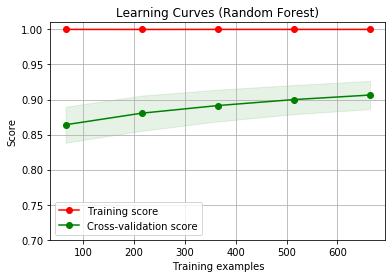

In [41]:
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
clf_curve = RandomForestClassifier(n_estimators=100, random_state=0,class_weight={"substrate":2},n_jobs=4)
plot_learning_curve(clf_curve, title, trainingSet, trainingSet_y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)